In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time

# Get Data

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
image_size = 28
num_classes = 10

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [3]:
def display(val):
    image = mnist.train.images[val].reshape([image_size, image_size])
    label = mnist.train.labels[val].argmax()
    plt.title('Training: %d  Label: %d' % (val, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()

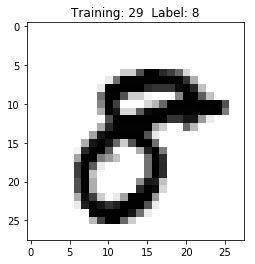

In [4]:
display(29)

# CNN Building Blocks

In [5]:
def createConvolutionLayer(x_input, kernel_size, features, depth):
    # createConvolutionLayer generates a convolution layer in the session graph
    # by assigning weights, biases, convolution and relu function
    #
    # x_input - output from the previous layer
    # kernel_size - size of the feature kernels
    # depth - number of feature kernels
    #
    # returns convolution layer in graph
    #
    print("conv: input size: " + str(x_input.get_shape()))
    weights = tf.get_variable('weights', shape=[kernel_size, kernel_size, features, depth],
                             initializer = tf.contrib.layers.xavier_initializer())
    
    biases = tf.get_variable('biases', shape=[depth], initializer=tf.constant_initializer(0))
    print("shape:" + str(x_input.get_shape()))
    print("shape:" + str(weights.get_shape()))
    convolution = tf.nn.conv2d(x_input, weights, strides=[1,1,1,1], padding='SAME')
    print("shape:" + str(convolution.get_shape()))
    added = tf.nn.bias_add(convolution, biases)
    
    return tf.nn.relu(added), weights

In [6]:
def createFullyConnectedLayer(x_input, width):
    # createFullyConnectedLayer generates a fully connected layer in the session graph
    # 
    # x_input - output from previous layer
    # width - width of the layer (eg for a 10 class output you need to end with a 10 width layer
    #
    # returns fully connected layer in graph
    #
    print("fc: input size: " + str(x_input.get_shape()))
    weights = tf.get_variable('weights', shape=[x_input.get_shape()[1], width],
                             initializer = tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable('biases', shape=[width], initializer=tf.constant_initializer(0))
     
    matrix_multiply = tf.matmul(x_input, weights)
    
    return tf.nn.bias_add(matrix_multiply, biases)

In [7]:
def createSoftmaxLayer(x_input, width):
    # createSoftmaxLayer generates a softmax layer in the session graph
    # 
    # x_input - output from previous layer
    # width - width of the layer (eg for a 10 class output you need to end with a 10 width layer
    #
    # returns softmax layer in graph
    #
    print("softmax: input size: " + str(x_input.get_shape()))
    weights = tf.get_variable('weights', shape=[x_input.get_shape()[1], width],
                             initializer = tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable('biases', shape=[width], initializer=tf.constant_initializer(0))
    
    matrix_multiply = tf.matmul(x_input, weights)
    
    return tf.nn.softmax(tf.nn.bias_add(matrix_multiply, biases))

In [8]:
def createLinearRectifier(x_input):
    # createLinearRectifier generates a ReLu in the session graph
    # 
    # The reason this exists is due to the last fully connected layer not needing a relu while others do
    # x_input - output from previous layer
    # width - width of the layer
    #
    # returns ReLu in graph
    # 
    
    return tf.nn.relu(x_input)

In [9]:
def createPoolingLayer(x_input, kernel_size):
    # createPoolingLayer generates a pooling layer in the session graph
    # 
    # The reason this exists is due to the last fully connected layer not needing a relu while others do
    # x_input - output from previous layer
    # kernel_size - size of the kernel
    #
    # returns pooling layer in graph
    # 
    print("pool: input size: " + str(x_input.get_shape()))
    return tf.nn.max_pool(x_input, ksize=[1, kernel_size, kernel_size, 1], strides=[1,kernel_size,kernel_size, 1], padding='SAME')

In [10]:
def createNetwork(x_input, is_training):
    with tf.variable_scope('conv1'):
        print("shape:" + str(x_input.get_shape()))
        convolution_layer1, weights1 = createConvolutionLayer(x_input, 5, 1, 32)
        print("shape:" + str(convolution_layer1.get_shape()))
        pooling_layer1 = createPoolingLayer(convolution_layer1, 2)
    with tf.variable_scope('conv2'):
        convolution_layer2, weights2 = createConvolutionLayer(pooling_layer1, 5, 32, 64)
        pooling_layer1 = createPoolingLayer(convolution_layer2, 2)
        pooling_layer1_shape = pooling_layer1.get_shape().as_list()
        pooling_layer1_flattened = tf.reshape(pooling_layer1, [-1, pooling_layer1_shape[1] * pooling_layer1_shape[2] * pooling_layer1_shape[3]])
    with tf.variable_scope('fc1'):
        fully_connected_layer1 = createFullyConnectedLayer(pooling_layer1_flattened, 1024)
        fully_connected_relu1 = createLinearRectifier(fully_connected_layer1)
        #fully_connected_relu1 = tf.cond(is_training, lambda: tf.nn.dropout(fully_connected_relu1, keep_prob=0.5), lambda: fully_connected_relu1)
    with tf.variable_scope('softmax'):
        output = createSoftmaxLayer(fully_connected_relu1, 10)
        
    return output

In [11]:
graph = tf.Graph()

with graph.as_default():
    
    x_input = tf.placeholder(tf.float32, shape=[None, image_size * image_size])
    y_output = tf.placeholder(tf.float32, shape=[None, num_classes])
    is_training = tf.placeholder(tf.bool)

    #learning rate
    learning_rate = 0.0001
    
    # get model
    x_image = tf.reshape(x_input, [-1, 28, 28, 1])
    prediction_output = createNetwork(x_image, is_training)
    
    correct_prediction = tf.equal(tf.argmax(y_output,1), tf.argmax(prediction_output,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    loss_function = tf.reduce_mean(-tf.reduce_sum(y_output * tf.log(prediction_output), reduction_indices=[1]))

    #optimization method
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss_function)

shape:(?, 28, 28, 1)
conv: input size: (?, 28, 28, 1)
shape:(?, 28, 28, 1)
shape:(5, 5, 1, 32)
shape:(?, 28, 28, 32)
shape:(?, 28, 28, 32)
pool: input size: (?, 28, 28, 32)
conv: input size: (?, 14, 14, 32)
shape:(?, 14, 14, 32)
shape:(5, 5, 32, 64)
shape:(?, 14, 14, 64)
pool: input size: (?, 14, 14, 64)
fc: input size: (?, 3136)
softmax: input size: (?, 1024)


In [13]:
model_name = "CNN" + "LRN" + str(learning_rate) + "EP" + str(iterations) + "DRP" 
model_filename = model_name + "Model.ckpt"
model_directory = os.getcwd() + "/Models/" + model_name
model_path = model_directory + "/" + model_filename

In [33]:
batch_size = 64
start = time.time()
train_loss_list = []
valid_loss_list = []
time_list = []
epoch_list = []
print("TRAINING: " + model_name)
with tf.Session(graph = graph) as session:
    session.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    if os.path.exists(model_directory):
            load_path = saver.restore(session, model_path)
    for i in range(10000):
        batch = mnist.train.next_batch(batch_size)
        if i%100 == 0:
            feed_dict = {x_input:batch[0], y_output: batch[1], is_training: False}
            train_accuracy = accuracy.eval(feed_dict=feed_dict)
            train_loss = session.run(loss_function, feed_dict=feed_dict)
            print("step " + str(i) + " Train Acc: " + str(train_accuracy) + " Train Loss: " + str(train_loss))
        # Train system
        session.run([optimizer], feed_dict={x_input: batch[0], y_output: batch[1], is_training: True})
    train_loss = session.run(loss_function, feed_dict = {x_input: mnist.test.images, y_output: mnist.test.labels, is_training: False})
    test_accuracy = accuracy.eval(feed_dict={ x_input: mnist.test.images, y_output: mnist.test.labels, is_training: False})
    print("Final: " " Test Acc: " + str(test_accuracy) + " Test Loss: " + str(test_loss))

TRAINING: CNNLRN0.0001EP10DRP
step 0 Train Acc: 0.09375 Train Loss: 2.30706
step 100 Train Acc: 0.9375 Train Loss: 0.243375
step 200 Train Acc: 0.890625 Train Loss: 0.418127
step 300 Train Acc: 0.9375 Train Loss: 0.153159
step 400 Train Acc: 0.984375 Train Loss: 0.0993362
step 500 Train Acc: 0.90625 Train Loss: 0.208997
step 600 Train Acc: 0.953125 Train Loss: 0.221878
step 700 Train Acc: 0.9375 Train Loss: 0.184365
step 800 Train Acc: 0.953125 Train Loss: 0.139517
step 900 Train Acc: 0.953125 Train Loss: 0.103535
step 1000 Train Acc: 1.0 Train Loss: 0.0415429
step 1100 Train Acc: 0.96875 Train Loss: 0.0545608
step 1200 Train Acc: 1.0 Train Loss: 0.0335335
step 1300 Train Acc: 0.96875 Train Loss: 0.106182
step 1400 Train Acc: 0.953125 Train Loss: 0.158425
step 1500 Train Acc: 0.984375 Train Loss: 0.0692326
step 1600 Train Acc: 0.96875 Train Loss: 0.184793
step 1700 Train Acc: 0.984375 Train Loss: 0.0409942
step 1800 Train Acc: 0.984375 Train Loss: 0.0684483
step 1900 Train Acc: 0.98437

NameError: name 'test_loss' is not defined

In [ ]:
# Create a Pandas dataframe from some data.
df = pd.DataFrame({'Data': [p]})

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(model_path + 'TrainLossAcc.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()